
# Simple linear regression example

The model equation is y = ax + b with a, b being the model parameters, while the
likelihood model is based on a normal zero-mean additive model error distribution with
the standard deviation to infer. The problem is solved via maximum likelihood estimation
as well as via sampling using emcee.


First, let's import the required functions and classes for this example.



In [1]:
# third party imports
import numpy as np
import matplotlib.pyplot as plt

# local imports (problem definition)
from probeye.definition.inverse_problem import InverseProblem
from probeye.definition.forward_model import ForwardModelBase
from probeye.definition.distribution import Normal, Uniform, SpikeAndSlab, Bernoulli, RegularisedHorseShoe, HalfCauchy, InvGamma, HorseShoe
from probeye.definition.sensor import Sensor
from probeye.definition.likelihood_model import GaussianLikelihoodModel

# local imports (problem solving)
from probeye.inference.scipy.solver import MaxLikelihoodSolver
from probeye.inference.emcee.solver import EmceeSolver
from probeye.inference.dynesty.solver import DynestySolver

# local imports (inference data post-processing)
from probeye.postprocessing.sampling_plots import create_pair_plot
from probeye.postprocessing.sampling_plots import create_posterior_plot
from probeye.postprocessing.sampling_plots import create_trace_plot

We start by generating a synthetic data set from a known linear model to which we will
add some noise. Afterwards, we will pretend to have forgotten the parameters of this
ground-truth model and will instead try to recover them just from the data. The slope
(a) and intercept (b) of the ground truth model are set to be:



In [2]:
# ground truth
a_true = 8
b_true = 10

Now, let's generate a few data points that we contaminate with a Gaussian error:



In [3]:
# settings for data generation
n_tests = 50
seed = 1
mean_noise = 0.0
std_noise = 1

# generate the data
np.random.seed(seed)
x_test = np.linspace(-4.0, 4.0, n_tests)
y_true = a_true * x_test ** 2  #a_true * x_test**2 #+ b_true * x_test + c_true #a_true * x_test**2 + 
y_test = y_true + np.random.normal(loc=mean_noise, scale=std_noise, size=n_tests)

Let's take a look at the data that we just generated:



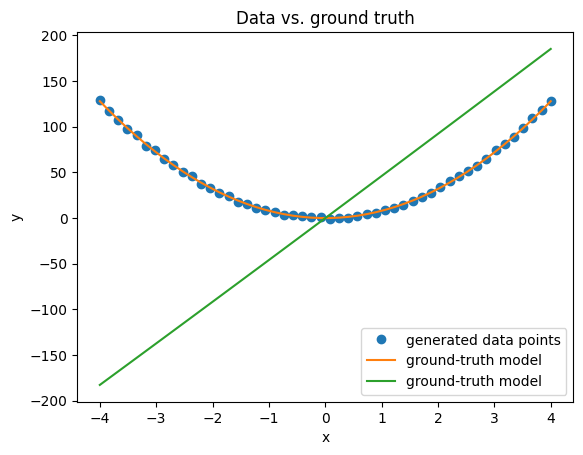

In [4]:
plt.plot(x_test, y_test, "o", label="generated data points")
plt.plot(x_test, y_true, label="ground-truth model")
plt.plot(x_test, 0.08 * x_test ** 2 + 46 * x_test , label="ground-truth model") #1*np.exp(x_test)
plt.title("Data vs. ground truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Until this point, we didn't use probeye at all, since we just generated some data. In
a normal use case, we wouldn't have to generate our data of course. Instead, it would
be provided to us, for example as the result of some test series. As the first step in
any calibration problem, one needs to have a parameterized model (in probeye such a
model is called 'forward model') of which one assumes that it is able to describe the
data at hand. In this case, if we took a look at the blue data points in the plot
above without knowing the orange line, we might expect a simple linear model. It is
now our job to describe this model within the probeye-framework. This is done by
defining our own specific model class:



In [5]:
class LinearModel(ForwardModelBase):
    def interface(self):
        self.parameters = ["a", "b"] #, "c"
        self.input_sensors = Sensor("x")
        self.output_sensors = Sensor("y", std_model="sigma")

    def response(self, inp: dict) -> dict:
        x = inp["x"]
        a = inp["a"]
        b = inp["b"]
        return {"y":  a * x ** 2 + b * x} #a * x ** 2 + 

First, note that this model class is based on the probeye class 'ForwardModelBase'.
While this is a requirement, the name of the class can be chosen freely. As you can
see, this class has an 'interface' and a 'response' method. In the 'interface' method
we define that our model has two parameters, 'a' and 'b', next to one input and one
output sensors, called 'x' and 'y' respectively. Keeping this interface in mind,
let's now take a look at the 'response' method. This method describes the actual
forward model evaluation. The method takes one dictionary as an input and returns one
dictionary as its output. The input dictionary 'inp' will have the keys 'a', 'b' and
'x' because of the definitions given in self.interface. Analogously, the returned
dictionary must have the key 'y', because we defined an output sensor with the name
'y'. Note that the entire interface of the 'response' method is described by the
'interface' method. Parameters and input sensors will be contained in the 'inp'
dictionary, while the output sensors must be contained in the returned dictionary.



After we now have defined our forward model, we can set up the inverse problem
itself. This always begins by initializing an object form the InverseProblem-class,
and adding all of the problem's parameters with priors that reflect our current best
guesses of what the parameter's values might look like. Please check out the
'Components'-part of this documentation to get more information on the arguments seen
below. However, most of the code should be self-explanatory.



As the next step, we need to add our experimental data the forward model and the
likelihood model. Note that the order is important and should not be changed.



In [6]:
# initialize the problem (the print_header=False is only set to avoid the printout of
# the probeye header which is not helpful here)
problem = InverseProblem("Linear regression with Gaussian noise", print_header=False)

# add the problem's parameters
problem.add_parameter(
    "lmbda_a",
    #tex="$\lambda_a$",
    #info="Lambda of Slope of the graph",
    #domain="[0, +oo)",
    prior=HalfCauchy(loc=0, scale=1),
)

problem.add_parameter(
    "tau_a",
    #tex="$\lambda_a$",
    #info="Lambda of Slope of the graph",
    #domain="[0, +oo)",
    prior=HalfCauchy(loc=0, scale=0.1),
)

problem.add_parameter(
    "a",
    tex="$a$",
    #info="Slope of the graph",
    prior=HorseShoe(mean=0, lmbda="lmbda_a", tau="tau_a"),
)
#################################################################################################################

problem.add_parameter(
    "lmbda_b",
    #tex="$\lambda_a$",
    #info="Lambda of Slope of the graph",
    #domain="[0, +oo)",
    prior=HalfCauchy(loc=0, scale=1),
)

problem.add_parameter(
    "tau_b",
    #tex="$\lambda_a$",
    #info="Lambda of Slope of the graph",
    #domain="[0, +oo)",
    prior=HalfCauchy(loc=0, scale=0.1),
)

problem.add_parameter(
    "b",
    #tex="$a$",
    #info="Slope of the graph",
    prior=HorseShoe(mean=0, lmbda="lmbda_b", tau="tau_b"),
)

problem.add_parameter(
    "sigma",
    domain="(0, +oo)",
    tex=r"$\sigma$",
    info="Standard deviation, of zero-mean Gaussian noise model",
    #prior=Uniform(low=0.0, high=1.5),
    value = 1.0
)


In [ ]:
# initialize the problem (the print_header=False is only set to avoid the printout of
# the probeye header which is not helpful here)
problem = InverseProblem("Linear regression with Gaussian noise", print_header=False)

# add the problem's parameters
problem.add_parameter(
    "lmbda_a",
    tex="$\lambda_a$",
    #info="Lambda of Slope of the graph",
    prior=Bernoulli(prob=0.5),
)
problem.add_parameter(
    "a",
    tex="$a$",
    #info="Slope of the graph",
    prior=SpikeAndSlab(mean=7, std=2.5, lmbda="lmbda_a"),
)
problem.add_parameter(
    "lmbda_b",
    tex="$\lambda_b$",
    #info="Lambda of Slope of the graph",
    prior=Bernoulli(prob=0.5),
)
problem.add_parameter(
    "b",
    #info="Intersection of graph with y-axis",
    tex="$b$",
    prior=SpikeAndSlab(mean=0, std=2, lmbda="lmbda_b"),
)
problem.add_parameter(
    "sigma",
    domain="(0, +oo)",
    tex=r"$\sigma$",
    info="Standard deviation, of zero-mean Gaussian noise model",
    #prior=Uniform(low=0.0, high=1.5),
    value = 1.0
)

In [7]:
# experimental data
problem.add_experiment(
    name="TestSeries_1",
    sensor_data={"x": x_test, "y": y_test},
)

# forward model
problem.add_forward_model(LinearModel("LinearModel"), experiments="TestSeries_1")

# likelihood model
problem.add_likelihood_model(
    GaussianLikelihoodModel(experiment_name="TestSeries_1", model_error="additive")
)

Now, our problem definition is complete, and we can take a look at its summary:



In [8]:
# print problem summary
problem.info(print_header=True)


2023-09-21 11:08:58.408 | INFO     | # ================================================================================================ # | probeye.subroutines:print_probeye_header:620
2023-09-21 11:08:58.409 | INFO     | #                                                                                                  # | probeye.subroutines:print_probeye_header:620
2023-09-21 11:08:58.409 | INFO     | #                                            dP                                                    # | probeye.subroutines:print_probeye_header:620
2023-09-21 11:08:58.410 | INFO     | #                                            88                                                    # | probeye.subroutines:print_probeye_header:620
2023-09-21 11:08:58.411 | INFO     | #                  88d888b. 88d888b..d8888b. 88d888b. .d8888b. dP    dP .d8888b.                   # | probeye.subroutines:print_probeye_header:620
2023-09-21 11:08:58.411 | INFO     | #                  88'  `88 88'     8

After the problem definition comes the problem solution. There are different solver
one can use, but we will just demonstrate how to use two of them: the scipy-solver,
which merely provides a point estimate based on a maximum likelihood optimization, and
the emcee solver, which is a MCMC-sampling solver. Let's begin with the scipy-solver:



All solver have in common that they are first initialized, and then execute a
run-method, which returns its result data in the format of an arviz inference-data
object (except for the scipy-solver). Let's now take a look at the emcee-solver.



In [9]:
# this is for using the emcee-solver (MCMC sampling)
emcee_solver = EmceeSolver(problem, show_progress=True)
inference_data = emcee_solver.run(n_steps=3300, n_initial_steps=1100, n_walkers=20)
posterior = emcee_solver.raw_results.get_chain()

2023-09-21 11:09:00.466 | INFO     | Solving problem using emcee sampler with 1100 + 3300 samples and 20 walkers                          | probeye.inference.emcee.solver:run:178
2023-09-21 11:09:00.467 | INFO     | No additional options specified                                                                      | probeye.inference.emcee.solver:run:186


100%|██████████| 3300/3300 [00:25<00:00, 127.79it/s]

2023-09-21 11:09:35.049 | INFO     | Sampling of the posterior distribution completed: 3300 steps and 20 walkers.                         | probeye.inference.emcee.solver:run:280
2023-09-21 11:09:35.050 | INFO     | Total run-time (including initial sampling): 34s.                                                    | probeye.inference.emcee.solver:run:284
2023-09-21 11:09:35.050 | INFO     |                                                                                                      | probeye.inference.emcee.solver:run:285
2023-09-21 11:09:35.050 | INFO     | Summary of sampling results (emcee)                                                                  | probeye.inference.emcee.solver:run:286
2023-09-21 11:09:35.066 | INFO     |            mean    median     sd     5%    95%                                                       | probeye.inference.emcee.solver:emcee_summary:137
2023-09-21 11:09:35.067 | INFO     | -------  ------  --------  -----  -----  -----            

Finally, we want to plot the results we obtained. To that end, probeye provides some
post-processing routines, which are mostly based on the arviz-plotting routines.



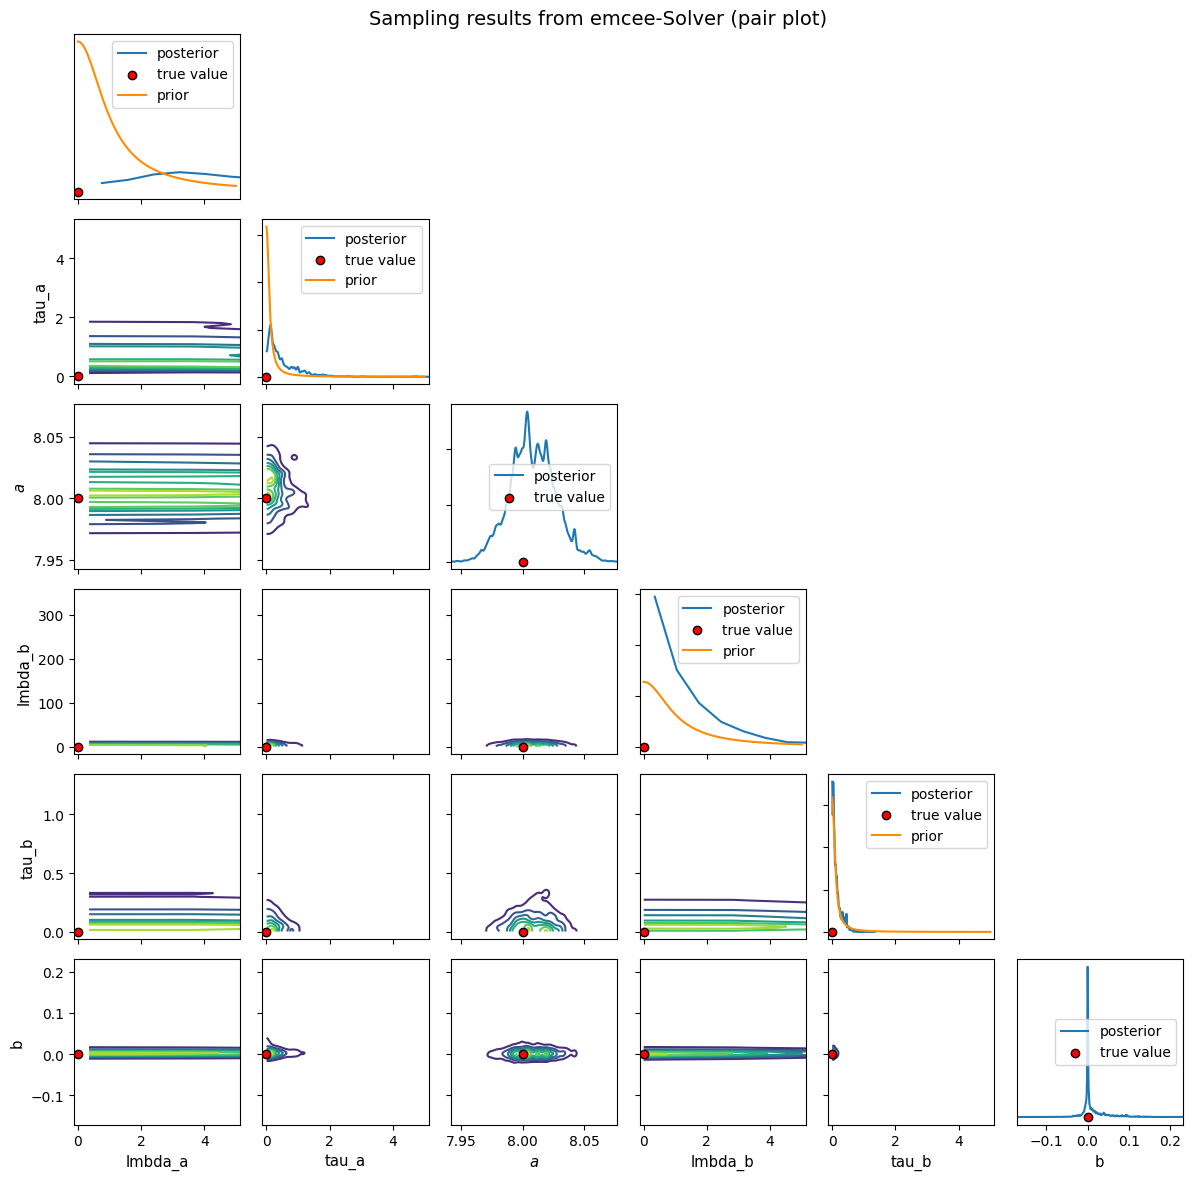

In [12]:
# this is optional, since in most cases we don't know the ground truth
true_values = {"a": a_true, "b": 0, "lmbda_a": 0, "tau_a": 0, "lmbda_b": 0, "tau_b": 0}

#true_values = {"a": 0, "b": b_true, "lmbda_a": 0, "sigma": std_noise}

# this is an overview plot that allows to visualize correlations
pair_plot_array = create_pair_plot(
    inference_data, 
    emcee_solver.problem,
    true_values=true_values,
    focus_on_posterior=True,
    show_legends=True,
    title="Sampling results from emcee-Solver (pair plot)",
)

In [ ]:
# this is a posterior plot, without including priors
post_plot_array = create_posterior_plot(
    inference_data,
    emcee_solver.problem,
    true_values=true_values,
    title="Sampling results from emcee-Solver (posterior plot)",
)

In [ ]:
# trace plots are used to check for "healthy" sampling
trace_plot_array = create_trace_plot(
    inference_data,
    emcee_solver.problem,
    title="Sampling results from emcee-Solver (trace plot)",
)

In [ ]:
plt.plot(x_test, y_test, "o", label="generated data points")
plt.plot(x_test, y_true, label="ground-truth model")
plt.plot(x_test, -0.9*np.exp(-x_test) -10 , label="ground-truth model")
plt.title("Data vs. ground truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()